In [3]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import geopandas as gpd
import shapely
from typing import Iterable, Tuple, Dict

import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import SRC_PATH
from src.data_loading.rasterio_utils import polygonise
from src.data_loading.vector_utils import shapely_to_frame
from src.tests.utils import polygonise_sub_array, plot_identified_nodes, get_array_transform
from src.models.geograph import GeoGraph
from src.models.binary_graph_operations import identify_node

In [6]:
def _split_array_in_four(arr):
    
    x_size, y_size = arr.shape[::-1]
    
    return {"upper_left": ((0,x_size//2), (y_size//2, None)),
            "lower_left": ((0,x_size//2), (0, y_size//2)),
            "upper_right": ((x_size//2, None), (y_size//2, None)),
            "lower_right":  ((x_size//2, None), (0, y_size//2))
           }



In [7]:
def polygonise_splits(arr: np.ndarray, 
                       named_slices: Iterable[Dict[str, Tuple]]
                      ):
    
    result = {}
    for name, (x_lims, y_lims) in named_slices.items(): 
        result[name] = polygonise_sub_array(arr, x_lims, y_lims)
        
    return result

# 1. Create test cases

In [8]:
TEST_DATA_FOLDER = SRC_PATH / "tests" / "testdata"
TEST_DATA_FOLDER.mkdir(parents=True, exist_ok=True)

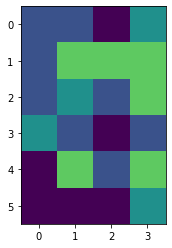

In [6]:
np.random.seed(28)
low = 1
high = 5
# Samples 1: Non-overlapping polygons
arr1 = np.random.randint(low=low, high=high, size=(6,4), dtype=np.uint8)
plt.imshow(arr1, vmin=low, vmax=high);

polys1 = polygonise_splits(arr1, _split_array_in_four(arr1))
polys1["full"] = polygonise(arr1, transform=get_array_transform(arr1))

#Saving
for name, df in polys1.items():
    save_path = TEST_DATA_FOLDER / "adjacent" / f"{name}.gpkg"
    df.to_file(save_path, driver="GPKG")

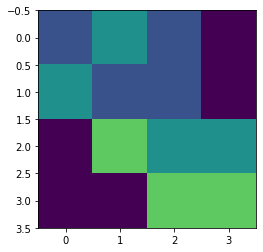

In [7]:
np.random.seed(285)
low = 1
high = 5
# Samples 2: Overlapping polygons
arr2 = np.random.randint(low=low, high=high, size=(4,4), dtype=np.uint8)
plt.imshow(arr2, vmin=low, vmax=high);

splits_of_interest = {
    "lower_left": ((0,3), (0,3)),
    "upper_right": ((1,4), (1,4)),
    "upper_left": ((0,3), (1,4)),
    "lower_right": ((1,4), (0,3))
}

polys2 = polygonise_splits(arr2, splits_of_interest)
polys2["full"] = polygonise(arr2, transform=get_array_transform(arr2))

#Saving
for name, df in polys2.items():
    save_path = TEST_DATA_FOLDER / "overlapping" / f"{name}.gpkg"
    df.to_file(save_path, driver="GPKG")

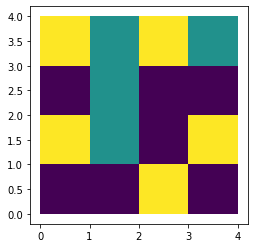

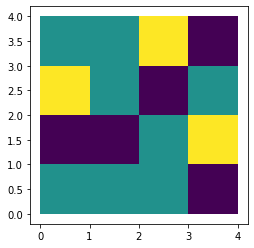

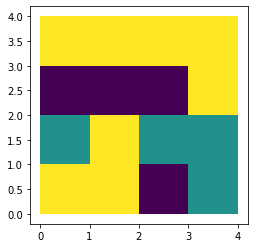

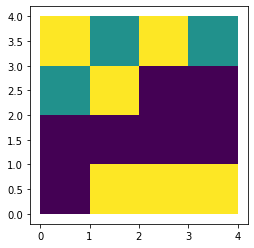

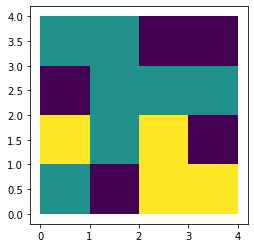

In [8]:
np.random.seed(184)

low = 1
high = 4

# Samples 3: Timeslices
for i in range(5):
    arr_t = np.random.randint(low=low, high=high, size=(4,4), dtype=np.uint8)
    
    polys_t = polygonise(arr_t, transform=get_array_transform(arr_t))
    polys_t.plot("class_label")
    
    save_path = TEST_DATA_FOLDER / "timestack" / f"time_{i}.gpkg"
    polys_t.to_file(save_path, driver="GPKG")

# 2. Load test cases

## 2.0 Helper funcs

### Plotting df from grpah 

In [9]:
def graph_df(graph):
    
    shapes = [node for _, node in graph.graph.nodes(data="geometry")]
    class_label = [node for _, node in graph.graph.nodes(data="class_label")]
    node_id = [idx for idx in graph.graph.nodes]
    return shapely_to_frame(shapes, class_label=class_label, node_id=node_id)

### Identify nodes

## 2.1 Adjacent case

In [11]:
full = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "full.gpkg")
upper_right = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "upper_right.gpkg")
upper_left = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "upper_left.gpkg")
lower_right = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "lower_right.gpkg")
lower_left = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "lower_left.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 15/15 [00:00<00:00, 678.58it/s]
Step 2 of 2: Adding edges: 100%|██████████| 15/15 [00:00<00:00, 29888.15it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 4/4 [00:00<00:00, 1036.08it/s]
Step 2 of 2: Adding edges: 100%|██████████| 4/4 [00:00<00:00, 23596.65it/s]


Graph successfully loaded with 15 nodes and 40 edges.
Graph successfully loaded with 4 nodes and 4 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 3/3 [00:00<00:00, 835.08it/s]
Step 2 of 2: Adding edges: 100%|██████████| 3/3 [00:00<00:00, 18450.02it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 961.04it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 23087.91it/s]


Graph successfully loaded with 3 nodes and 3 edges.
Graph successfully loaded with 6 nodes and 11 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 4/4 [00:00<00:00, 699.31it/s]
Step 2 of 2: Adding edges: 100%|██████████| 4/4 [00:00<00:00, 20661.60it/s]

Graph successfully loaded with 4 nodes and 6 edges.


<AxesSubplot:>

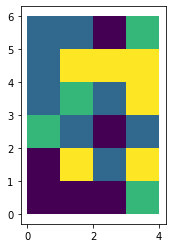

In [12]:
graph_df(full).plot("class_label")

#### Check node identification

[]
[]


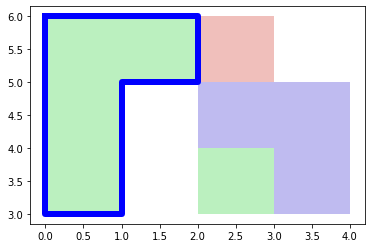

In [13]:
node = upper_left.graph.nodes[0]
other_graph = upper_right

print(identify_node(node, other_graph, mode="corner"))  # expected: [] since nodes of different class
print(identify_node(node, other_graph, mode="edge"))   # expected: [] since nodes of different class
plot_identified_nodes(node, other_graph, identify_node(node, other_graph, mode="interior"))

[2]


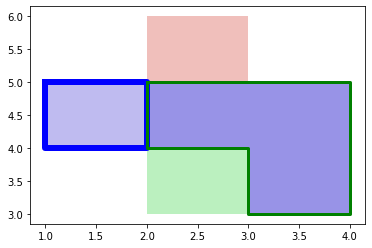

In [14]:
node = upper_left.graph.nodes[1]
other_graph = upper_right

print(identify_node(node, other_graph, mode="corner"))  # expected: [2] since same class and square touch
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))  # expected: [2] since same class and square touch

[]
[2]


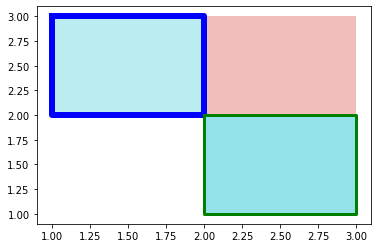

In [15]:
node = lower_left.graph.nodes[1]
other_graph = lower_right

print(identify_node(node, other_graph, mode="edge"))  # expected: [] since nodes touch only diagonally
print(identify_node(node, other_graph, mode="corner"))   # expected: [2] since nodes touch diagonally
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

## 2.2 Overlapping graph 

In [16]:
full = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "full.gpkg")
upper_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_right.gpkg")
upper_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "upper_left.gpkg")
lower_right = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_right.gpkg")
lower_left = GeoGraph(TEST_DATA_FOLDER / "overlapping" / "lower_left.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 9/9 [00:00<00:00, 663.99it/s]
Step 2 of 2: Adding edges: 100%|██████████| 9/9 [00:00<00:00, 31431.09it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 5/5 [00:00<00:00, 1046.22it/s]
Step 2 of 2: Adding edges: 100%|██████████| 5/5 [00:00<00:00, 20846.44it/s]


Graph successfully loaded with 9 nodes and 19 edges.
Graph successfully loaded with 5 nodes and 6 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 7/7 [00:00<00:00, 816.31it/s]
Step 2 of 2: Adding edges: 100%|██████████| 7/7 [00:00<00:00, 7321.73it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 776.00it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 24361.88it/s]


Graph successfully loaded with 7 nodes and 13 edges.
Graph successfully loaded with 6 nodes and 10 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 773.86it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 29228.60it/s]

Graph successfully loaded with 6 nodes and 12 edges.


<AxesSubplot:>

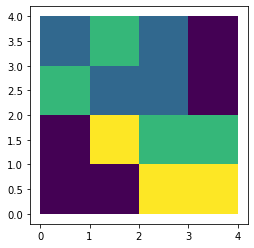

In [17]:
graph_df(full).plot("class_label")

[]
[0]


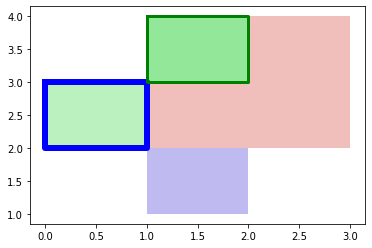

In [18]:
node = upper_left.graph.nodes[2]
other_graph = upper_right

print(identify_node(node, other_graph, mode="edge"))  # expected: [] since same class nodes overlap only diagonally
print(identify_node(node, other_graph, mode="corner"))   # expected: [0, 3] since same class nodes overlap only diagonally
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

[0]
[0]


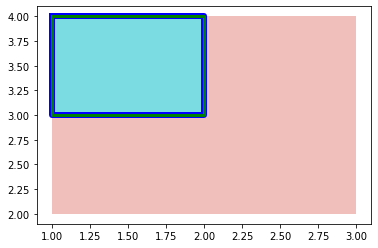

In [19]:
node = upper_left.graph.nodes[1]
other_graph = upper_right

print(identify_node(node, other_graph, mode="edge"))  # expected: [0] since nodes overlap entirely and same class
print(identify_node(node, other_graph, mode="interior"))   # expected: [0] since nodes overlap entirely and same class
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

[2]
[2]


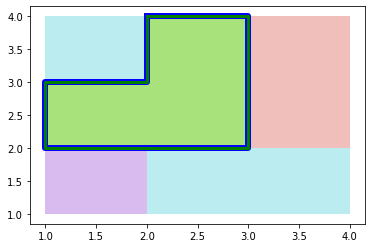

In [20]:
node = upper_left.graph.nodes[3]
other_graph = upper_right

print(identify_node(node, other_graph, mode="interior"))  # expected: [2] since nodes overlap entirely and same class
print(identify_node(node, other_graph, mode="corner"))   # expected: [2] since nodes overlap entirely and same class
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

[3]
[3]


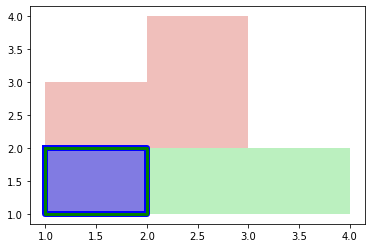

In [21]:
node = lower_right.graph.nodes[2]
other_graph = upper_right

print(identify_node(node, other_graph, mode="corner"))  # expected: [1] since nodes overlap partially and same class
print(identify_node(node, other_graph, mode="interior"))   # expected: [1] since nodes overlap partially and same class
plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

## 2.3 Timestacked graphs

In [22]:
t0 = GeoGraph(TEST_DATA_FOLDER / "timestack" / "time_0.gpkg")
t1 = GeoGraph(TEST_DATA_FOLDER / "timestack" / "time_1.gpkg")
t2 = GeoGraph(TEST_DATA_FOLDER / "timestack" / "time_2.gpkg")
t3 = GeoGraph(TEST_DATA_FOLDER / "timestack" / "time_3.gpkg")
t4 = GeoGraph(TEST_DATA_FOLDER / "timestack" / "time_4.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 11/11 [00:00<00:00, 549.42it/s]
Step 2 of 2: Adding edges: 100%|██████████| 11/11 [00:00<00:00, 33264.13it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 10/10 [00:00<00:00, 1270.04it/s]
Step 2 of 2: Adding edges: 100%|██████████| 10/10 [00:00<00:00, 68985.26it/s]


Graph successfully loaded with 11 nodes and 21 edges.
Graph successfully loaded with 10 nodes and 21 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 457.39it/s]
Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 27869.13it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 8/8 [00:00<00:00, 697.96it/s]
Step 2 of 2: Adding edges: 100%|██████████| 8/8 [00:00<00:00, 36080.03it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 8/8 [00:00<00:00, 1316.84it/s]
Step 2 of 2: Adding edges: 100%|██████████| 8/8 [00:00<00:00, 49272.29it/s]

Graph successfully loaded with 6 nodes and 9 edges.
Graph successfully loaded with 8 nodes and 15 edges.
Graph successfully loaded with 8 nodes and 13 edges.


<AxesSubplot:>

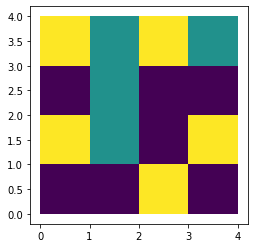

In [23]:
graph_df(t0).plot("class_label")

In [26]:
t0_to_t1 = {}

for mode in ["corner", "edge", "interior"]:
    for node_id, node in t0.graph.nodes(data=True):
        t0_to_t1[node_id] = identify_node(node, t1, mode=mode)
    print(mode, t0_to_t1)

corner {0: [3], 1: [0, 8], 2: [1], 3: [5], 4: [6], 5: [2, 4, 6, 9], 6: [3], 7: [7], 8: [6], 9: [7], 10: [9]}
edge {0: [3], 1: [0, 8], 2: [1], 3: [5], 4: [6], 5: [2, 4, 6], 6: [3], 7: [7], 8: [6], 9: [], 10: [9]}
interior {0: [], 1: [0], 2: [1], 3: [], 4: [], 5: [4], 6: [], 7: [7], 8: [], 9: [], 10: [9]}


<AxesSubplot:>

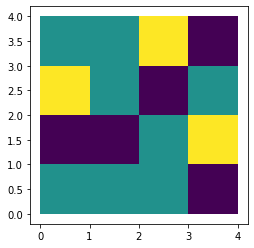

In [27]:
graph_df(t1).plot("class_label")

## 2.4 Note on timing

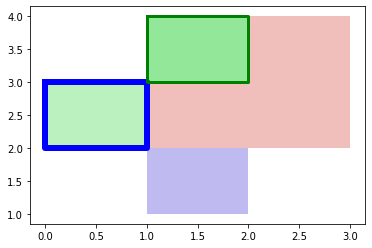

In [30]:
node = upper_left.graph.nodes[2]
other_graph = upper_right

plot_identified_nodes(node, other_graph, identify_node(node, other_graph))

In [31]:
%%timeit
identify_node(node, other_graph, mode="corner")

133 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [45]:
%%timeit
identify_node(node, other_graph, mode="edge")

178 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%%timeit
identify_node(node, other_graph, mode="interior")

187 µs ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%load_ext line_profiler

In [40]:
%lprun -f identify_node identify_node(node, other_graph, mode="corner")

Timer unit: 1e-06 s

Total time: 0.014375 s
File: <ipython-input-10-820b9bd79667>
Function: identify_node at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def identify_node(node, 
    35                                                             other_graph, 
    36                                                             mode = "corner"):
    37                                               
    38         1         13.0     13.0      0.1      assert mode in ["corner", "edge", "interior"]
    39         1          4.0      4.0      0.0      have_valid_overlap = spatial_polygon_identifier[mode]
    40         1          1.0      1.0      0.0      identifies_with = []
    41         4       6734.0   1683.5     46.8      for candidate_id in other_graph.rtree.intersection(node["geometry"].bounds):
    42                                           
    43         3         66.0     22.0      0.5          candidat

In [41]:
%lprun -f identify_node identify_node(node, other_graph, mode="edge")

Timer unit: 1e-06 s

Total time: 0.001171 s
File: <ipython-input-10-820b9bd79667>
Function: identify_node at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def identify_node(node, 
    35                                                             other_graph, 
    36                                                             mode = "corner"):
    37                                               
    38         1          3.0      3.0      0.3      assert mode in ["corner", "edge", "interior"]
    39         1          3.0      3.0      0.3      have_valid_overlap = spatial_polygon_identifier[mode]
    40         1          1.0      1.0      0.1      identifies_with = []
    41         4        678.0    169.5     57.9      for candidate_id in other_graph.rtree.intersection(node["geometry"].bounds):
    42                                           
    43         3         47.0     15.7      4.0          candidat

In [42]:
%lprun -f identify_node identify_node(node, other_graph, mode="interior")

Timer unit: 1e-06 s

Total time: 0.000586 s
File: <ipython-input-10-820b9bd79667>
Function: identify_node at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def identify_node(node, 
    35                                                             other_graph, 
    36                                                             mode = "corner"):
    37                                               
    38         1          2.0      2.0      0.3      assert mode in ["corner", "edge", "interior"]
    39         1          2.0      2.0      0.3      have_valid_overlap = spatial_polygon_identifier[mode]
    40         1          0.0      0.0      0.0      identifies_with = []
    41         4        387.0     96.8     66.0      for candidate_id in other_graph.rtree.intersection(node["geometry"].bounds):
    42                                           
    43         3         30.0     10.0      5.1          candidat

In [46]:
%%timeit
list(x for x in other_graph.rtree.intersection(node["geometry"].bounds))

117 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


------------

# Miscellaneous Experiments

For implementing more advanced relationship comparisons, [DE-IM9](https://shapely.readthedocs.io/en/stable/manual.html#de-9im-relationships) patterns 
are the way to go. [Wiki](https://en.wikipedia.org/wiki/DE-9IM)

Here's what shapely says about them:   
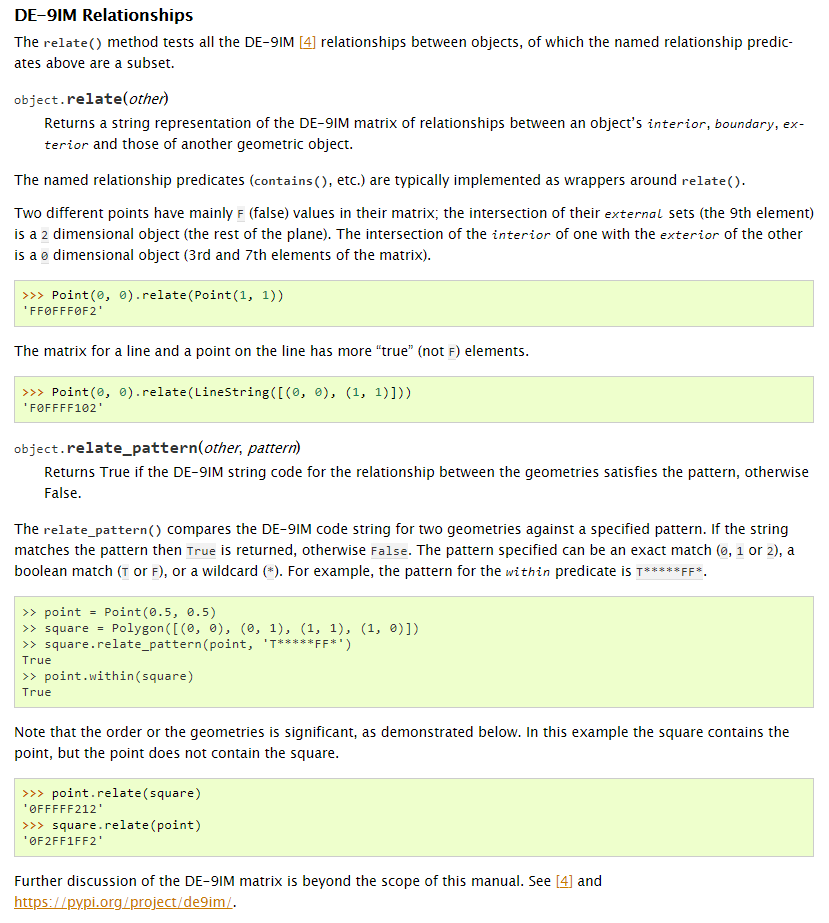

I want to capture shapes which
 - share any type of area
 - touch in at least a 1dim object

<AxesSubplot:>

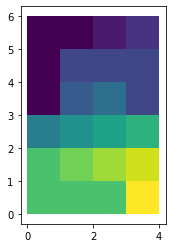

In [37]:
graph_df(full).plot("node_id")

In [46]:
n = lambda idx: full.graph.nodes[idx]["geometry"]

In [62]:
def intersects_but_not_diagonal(node1, node2):
    return node1.intersects(node2) and not node1.relate_pattern(node2, "FF*F0****")

In [48]:
n(1).relate(n(2))

'FF2F11212'

In [63]:
intersects_but_not_diagonal(n(1), n(2))

True

In [49]:
n(0).relate(n(2))

'FF2FF1212'

In [64]:
intersects_but_not_diagonal(n(0), n(2))

False

In [50]:
n(4).relate(n(6))

'FF2F01212'

In [66]:
intersects_but_not_diagonal(n(4), n(6))

False

In [30]:
%%timeit
node0["geometry"].relate_pattern(node1["geometry"], "T*****FF*")

27.7 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
%%timeit
node0["geometry"].relate(node1["geometry"])

42.8 µs ± 9.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
%%timeit
node0["geometry"].intersects(node1["geometry"])

4.58 µs ± 584 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [33]:
%%timeit
node0["geometry"].touches(node1["geometry"])

26.7 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
%%timeit
node0["geometry"].contains(node1["geometry"])  # why is this so fast when it is a wrapper around relate

2.99 µs ± 49.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [322]:
def de9im_extended_match(pattern, target_pattern):
    
    for char, target_char in zip(pattern, target_pattern):
        if target_char == "*": 
            continue
        elif target_char == "T" and char in "012":
            continue
        elif target_char == "S" and char in "01":
            continue
        elif target_char == "U" and char in "12":
            continue
        elif char == target_char:
            continue
        else:
            return False
    return True

In [326]:
de9im_extended_match('FF2F11212', "FF*FS****")

True

### Checking RTree

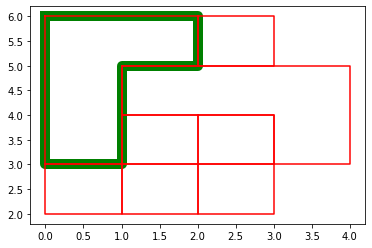

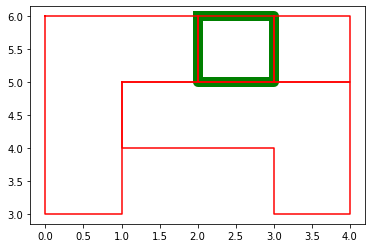

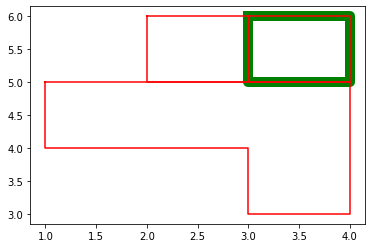

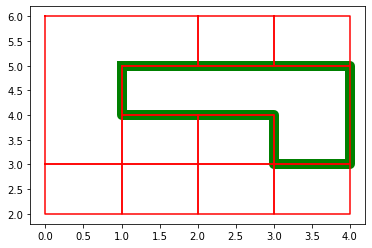

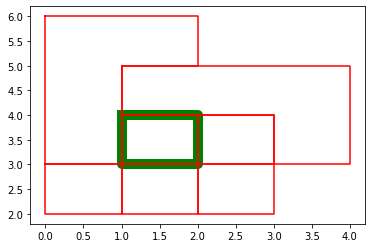

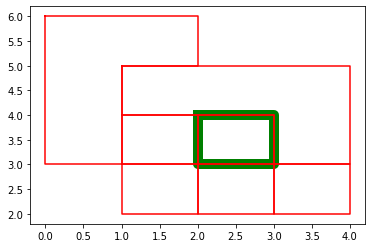

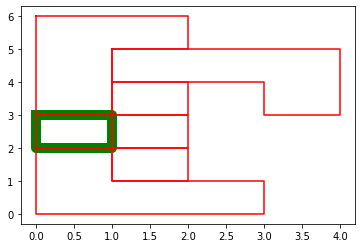

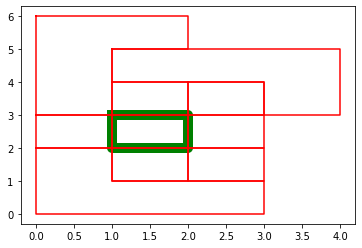

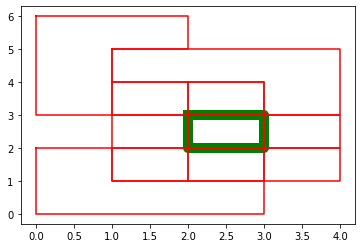

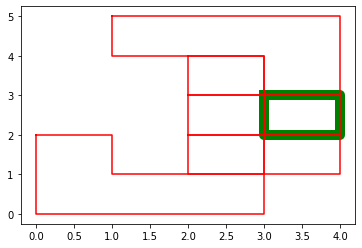

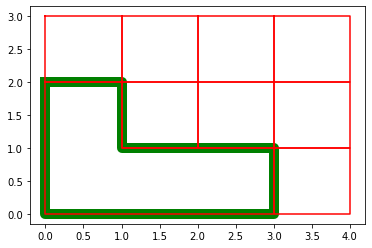

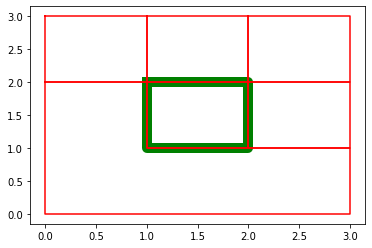

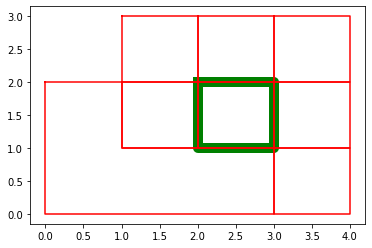

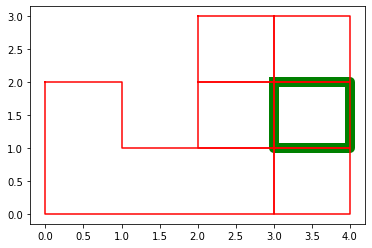

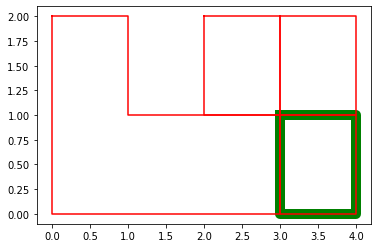

In [34]:
for _, node in full.graph.nodes(data=True):

    plt.plot(*node["geometry"].exterior.xy, color="green", linewidth=10)
    for elem in full.rtree.intersection(node["geometry"].bounds):
        poly = full.graph.nodes[elem]["geometry"]
        plt.plot(*poly.exterior.xy, color="red")
    plt.show()

### Deprecated

In [10]:
corner_only_pattern = "FF*F0****"
edge_only_pattern = "FF*F1****"
overlap_pattern = "T********"  # since we deal with polygons, if they overlap with more than edge, the interiors always overlap
have_same_class_label = lambda node1, node2: node1["class_label"] == node2["class_label"]

def de9im_match(pattern, target_pattern):
    
    for char, target_char in zip(pattern, target_pattern):
        if target_char == "*": 
            continue
        elif target_char == "T" and char in "012":
            continue
        elif char == target_char:
            continue
        else:
            return False
    return True

def _connects_with_interior_edge_or_corner(poly1, poly2):
    return poly1.intersects(poly2)

def _connects_with_interior_or_edge(poly1, poly2):
    pattern = poly1.relate(poly2)
    return de9im_match(pattern, edge_only_pattern) or de9im_match(pattern, overlap_pattern)

def _connects_with_interior(poly1, poly2):
    return poly1.relate_pattern(poly2, overlap_pattern)

spatial_polygon_identifier = {"corner": _connects_with_interior_edge_or_corner,
                              "edge": _connects_with_interior_or_edge,
                              "interior": _connects_with_interior
                             }
    
def identify_node(node, 
                  other_graph, 
                  mode = "corner"):
    
    assert mode in ["corner", "edge", "interior"]
    have_valid_overlap = spatial_polygon_identifier[mode]
    identifies_with = []
    for candidate_id in other_graph.rtree.intersection(node["geometry"].bounds):

        candidate_node = other_graph.graph.nodes[candidate_id]

        if have_same_class_label(node, candidate_node) and have_valid_overlap(node["geometry"], candidate_node["geometry"]):
            identifies_with.append(candidate_id)
            
    return identifies_with

In [295]:
has_same_class_label = lambda node1, node2: node1["class_label"] == node2["class_label"]
intersects = lambda node1, node2: node1["geometry"].intersects(node2["geometry"])
touches_only_corners = lambda node1, node2: node1["geometry"].relate_pattern(node2["geometry"], "FF*F0****")  
    
def identify_node(node, other_graph, allow_corners_only = True):
    
    identifies_with = []

    for candidate_id in other_graph.rtree.intersection(node["geometry"].bounds):

        candidate_node = other_graph.graph.nodes[candidate_id]

        if has_same_class_label(node, candidate_node) and intersects(node, candidate_node):
            if allow_corners_only or not touches_only_corners(node, candidate_node):
                identifies_with.append(candidate_id)
            
    return identifies_with

# Geograph improvements